In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
import scipy.signal
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

## 02 Loading the folder that contains our data

In [ ]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

In [5]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat']
event_data_df=[]

events_codes_all = {}
before_data_power_df=pd.DataFrame(columns=['mouse_id','task','channel_id','before_data_power'])
averaged_data=pd.DataFrame(columns=['mouse_id','task','channel_id','average_power_spectrum'])
averaged_data_welch=pd.DataFrame(columns=['mouse_id','task','channel_id','average_power_spectrum'])

for file in files:
    #if 'dk6' in file:
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, mouse_id, task = functions.exp_params(base_name)
        print(date, mouse_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, mouse_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)

        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)

        first_event = events_times[0]
        for channeli in channels:
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                normalized_data, time, data_before = functions.data_normalization(raw_data, raw_time, first_event, sampling_rate)
                
                # This makes a dataframe for calculating baseline power 
                before_data_power=functions.calculate_power_1D(data_before)
                before_data_row=pd.DataFrame({
                    'mouse_id':[mouse_id],'task':[task],'channel_id':[channel_id],'before_data_power':[before_data_power]})
                before_data_power_df=pd.concat([before_data_power_df,before_data_row],ignore_index=True)
                
                
                notch_filtered_data = functions.iir_notch(normalized_data, sampling_rate, 60)
                total = notch_filtered_data
                compiled_data = []
                power_spectra = []
                
                compiled_data_welch = []
                power_spectra_welch = []

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    event_time=np.linspace(0,2,2*sampling_rate)
                    event_row=[]
                    event_row.append(mouse_id)
                    event_row.append(task)
                    event_row.append(channeli)
                    event_row.append(i)

                    for event_data in event_data_list:
                        faxis, Sxx_event = functions.frequency_domain(event_data, event_time)
                        event_row.append(Sxx_event)

                    event_data_df.append(event_row)
                    faxis, Sxx = functions.frequency_domain(data_complete_trial, time)
                    f_w,sxx_w=scipy.signal.welch(data_complete_trial,sampling_rate,nperseg=1000)
                    compiled_data.append([i, faxis, Sxx])
                    power_spectra.append(Sxx)

                    compiled_data_welch.append([i, f_w, sxx_w])
                    power_spectra_welch.append(sxx_w)
                

                compiled_data_df = pd.DataFrame(compiled_data, columns=['Trial', 'Frequency Axis', 'Power Spectrum'])
                compiled_data_df_welch = pd.DataFrame(compiled_data_welch, columns=['Trial', 'Frequency Axis', 'Power Spectrum'])

                print(compiled_data_df.shape)

                # Ensure all power spectra have the same length
                min_length = min(len(spectrum) for spectrum in power_spectra)
                power_spectra = [spectrum[:min_length] for spectrum in power_spectra]

                min_length = min(len(spectrum) for spectrum in power_spectra_welch)
                power_spectra_welch = [spectrum[:min_length] for spectrum in power_spectra_welch]

                # Calculate the average power spectrum
                power_spectra = np.array(power_spectra)
                average_power_spectrum = np.mean(power_spectra, axis=0)
                row=pd.DataFrame({
                    'mouse_id':mouse_id,
                    'task':task,
                    'channel_id':channel_id,
                    'average_power_spectrum':[average_power_spectrum]
                })
                averaged_data=pd.concat([averaged_data,row])

                # Calculate the average power spectrum
                power_spectra_welch = np.array(power_spectra_welch)
                average_power_spectrum_welch = np.mean(power_spectra_welch, axis=0)
                row=pd.DataFrame({
                    'mouse_id':mouse_id,
                    'task':task,
                    'channel_id':channel_id,
                    'average_power_spectrum':[average_power_spectrum_welch]
                })
                averaged_data_welch=pd.concat([averaged_data_welch,row])

event_data_compiled_df = pd.DataFrame(event_data_df, columns=['mouse_id','task','channel_id','trial','door before', 'door after', 'dig before', 'dig after'])


In [ ]:
print(f_w)

We will plot the power of the first 30 seconds before the first event for each mouse

In [ ]:
import seaborn as sns
brain_areas = ['AON', 'vHp']
tasks = np.unique(before_data_power_df['task'])

fig,axs=plt.subplots(nrows=1, ncols=3, figsize=(20,10))
axs=axs.flatten()
for i,task in enumerate(tasks):
    task_dict={}
    task_df=before_data_power_df[before_data_power_df['task']==task]
    task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
    mouse_ids = np.unique(task_df['mouse_id'])

    for mouse in mouse_ids:
        task_dict[mouse]=np.array(task_df[task_df['mouse_id']==mouse]['before_data_power'])
    
    # Convert task_dict to a DataFrame
    task_df_csv = pd.DataFrame.from_dict(task_dict, orient='index').transpose()
    
    # Save the DataFrame as a CSV file
    task_df_csv.to_csv(os.path.join(savepath,f'task_{task}_baseline_power.csv'), index=False)
    
    #Plotting the thing
    ax=axs[i]
    sns.boxplot(x=task_df['mouse_id'], y=task_df['before_data_power'],showfliers=False, hue=task_df['channel_id'],ax=ax)
    sns.stripplot(x=task_df['mouse_id'], y=task_df['before_data_power'], hue=task_df['channel_id'],ax=ax, jitter=True, dodge=True,edgecolor='black',linewidth=1)

    ax.set_title(f'{task}')
fig.savefig(os.path.join(savepath,'baselinepower_indtask.png'),format='png',dpi=300, bbox_inches='tight')

we will plot baseline power for individual rat

In [ ]:
import seaborn as sns
brain_areas = ['AON', 'vHp']
rats = np.unique(before_data_power_df['mouse_id'])

fig,axs=plt.subplots(nrows=1, ncols=len(rats), figsize=(20,10))
axs=axs.flatten()
for i,rat in enumerate(rats):
    rat_dict={}
    rat_df=before_data_power_df[before_data_power_df['mouse_id']==rat]
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
    tasks = np.unique(rat_df['task'])

    for task in tasks:
        rat_dict[task]=np.array(rat_df[rat_df['task']==task]['before_data_power'])
    
    # Convert task_dict to a DataFrame
    rat_df_csv = pd.DataFrame.from_dict(rat_dict, orient='index').transpose()
    
    # Save the DataFrame as a CSV file
    rat_df_csv.to_csv(os.path.join(savepath,f'task_{rat}_baseline_power.csv'), index=False)
    
    #Plotting the thing
    ax=axs[i]
    sns.boxplot(x=rat_df['task'], y=rat_df['before_data_power'],showfliers=False, hue=rat_df['channel_id'],ax=ax)
    sns.stripplot(x=rat_df['task'], y=rat_df['before_data_power'], hue=rat_df['channel_id'],ax=ax, jitter=True, dodge=True,edgecolor='black',linewidth=1)

    ax.set_title(f'{rat}')
fig.savefig(os.path.join(savepath,'baselinepower_indrat.png'),format='png',dpi=300, bbox_inches='tight')

Now we will plot averaged power spectrum in a single plot for each mouse

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}
averaged_data=averaged_data
brain_areas = ['AON', 'vHp']
mouse_ids = np.unique(averaged_data['mouse_id'])
tasks = np.unique(averaged_data['task'])

for mouse in mouse_ids:
    mouse_data = averaged_data[averaged_data['mouse_id'] == mouse]

    fig, ax = plt.subplots(figsize=(20, 10))

    for i, task in enumerate(tasks):
        task_data = mouse_data[mouse_data['task'] == task]
        task_data = task_data.reset_index(drop=True)
        task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
        task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
        task_data_vhp = task_data_vhp.reset_index(drop=True)
        task_data_aon = task_data_aon.reset_index(drop=True)

        color_aon = color_scheme['AON'][i % len(color_scheme['AON'])]
        color_vhp = color_scheme['vHp'][i % len(color_scheme['vHp'])]

        if not task_data_vhp.empty:
            # Ensure all power spectra have the same length
            min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
            task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
            task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
            
            faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))

            ax.plot(faxis,task_data_vhp_mean, label=f'vHp_{task}', color=color_vhp)

        if not task_data_aon.empty:
            # Ensure all power spectra have the same length
            min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
            task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
            task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
            faxis=np.linspace(0,1000,num=len(task_data_aon_mean))
            ax.plot(faxis, task_data_aon_mean, label=f'AON_{task}', color=color_aon)

    ax.set_xlim(0, 100)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_title(f'Average Power Spectrum by Task and Brain Area for Mouse {mouse}')
    ax.legend()
    fig.savefig(os.path.join(savepath,f'average_power_spectrum_complete_trial_{mouse}.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
!pip install xlsxwriter

   ---------------------------------------- 0.0/159.9 kB ? eta -:--:--
   -- ------------------------------------- 10.2/159.9 kB ? eta -:--:--
   ------- ------------------------------- 30.7/159.9 kB 435.7 kB/s eta 0:00:01
   -------------- ------------------------ 61.4/159.9 kB 656.4 kB/s eta 0:00:01
   -------------------------------------- - 153.6/159.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 159.9/159.9 kB 1.1 MB/s eta 0:00:00


## Now we will make averaged power spectrum around events for each rat

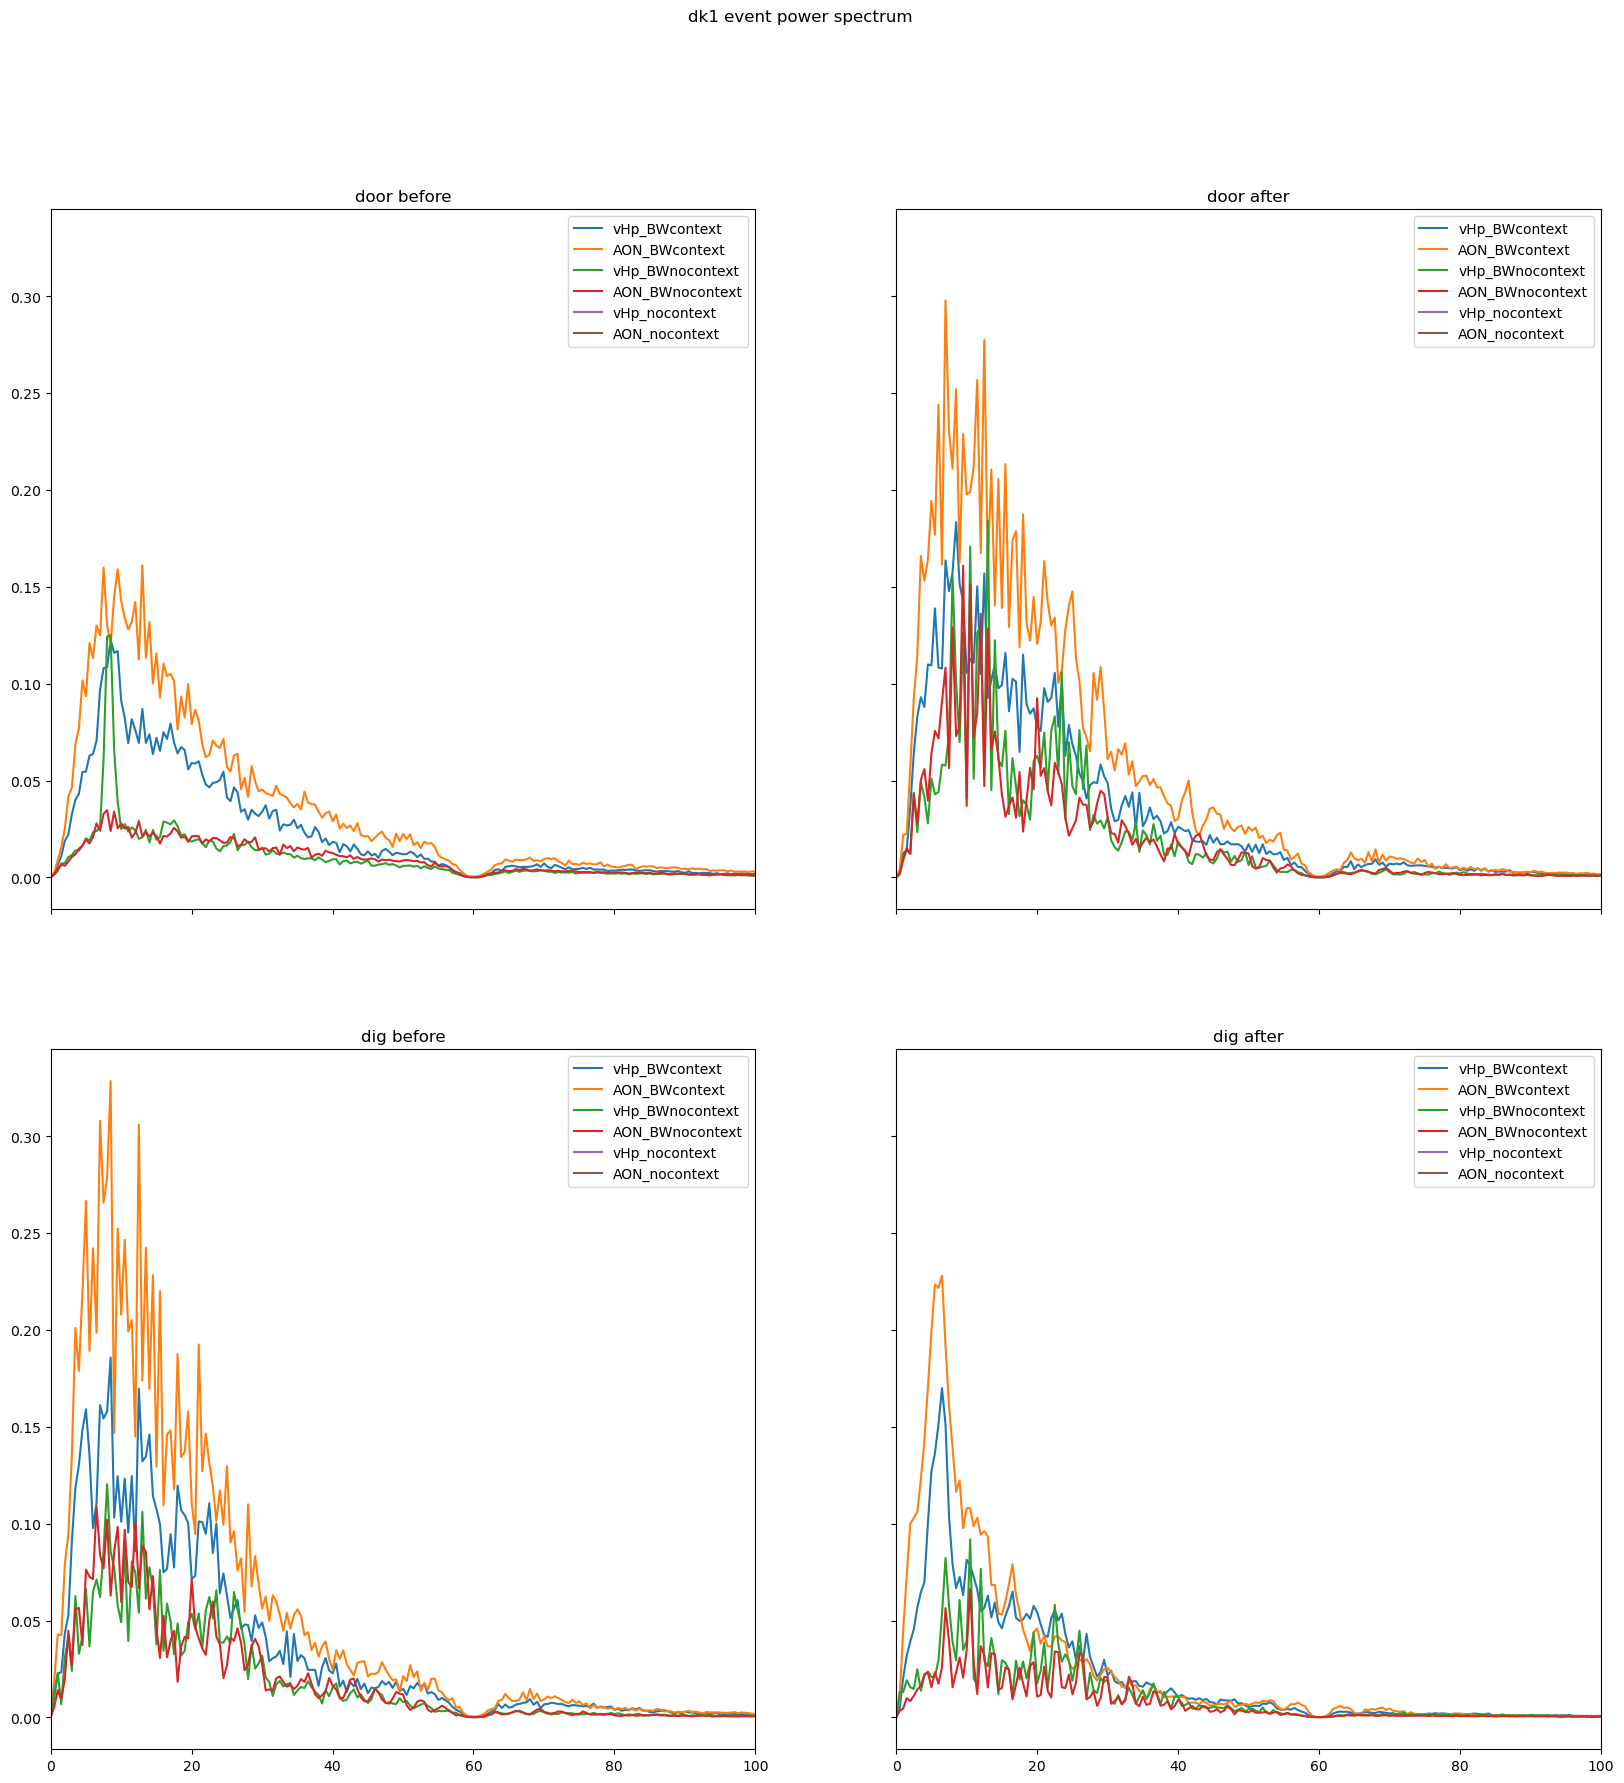

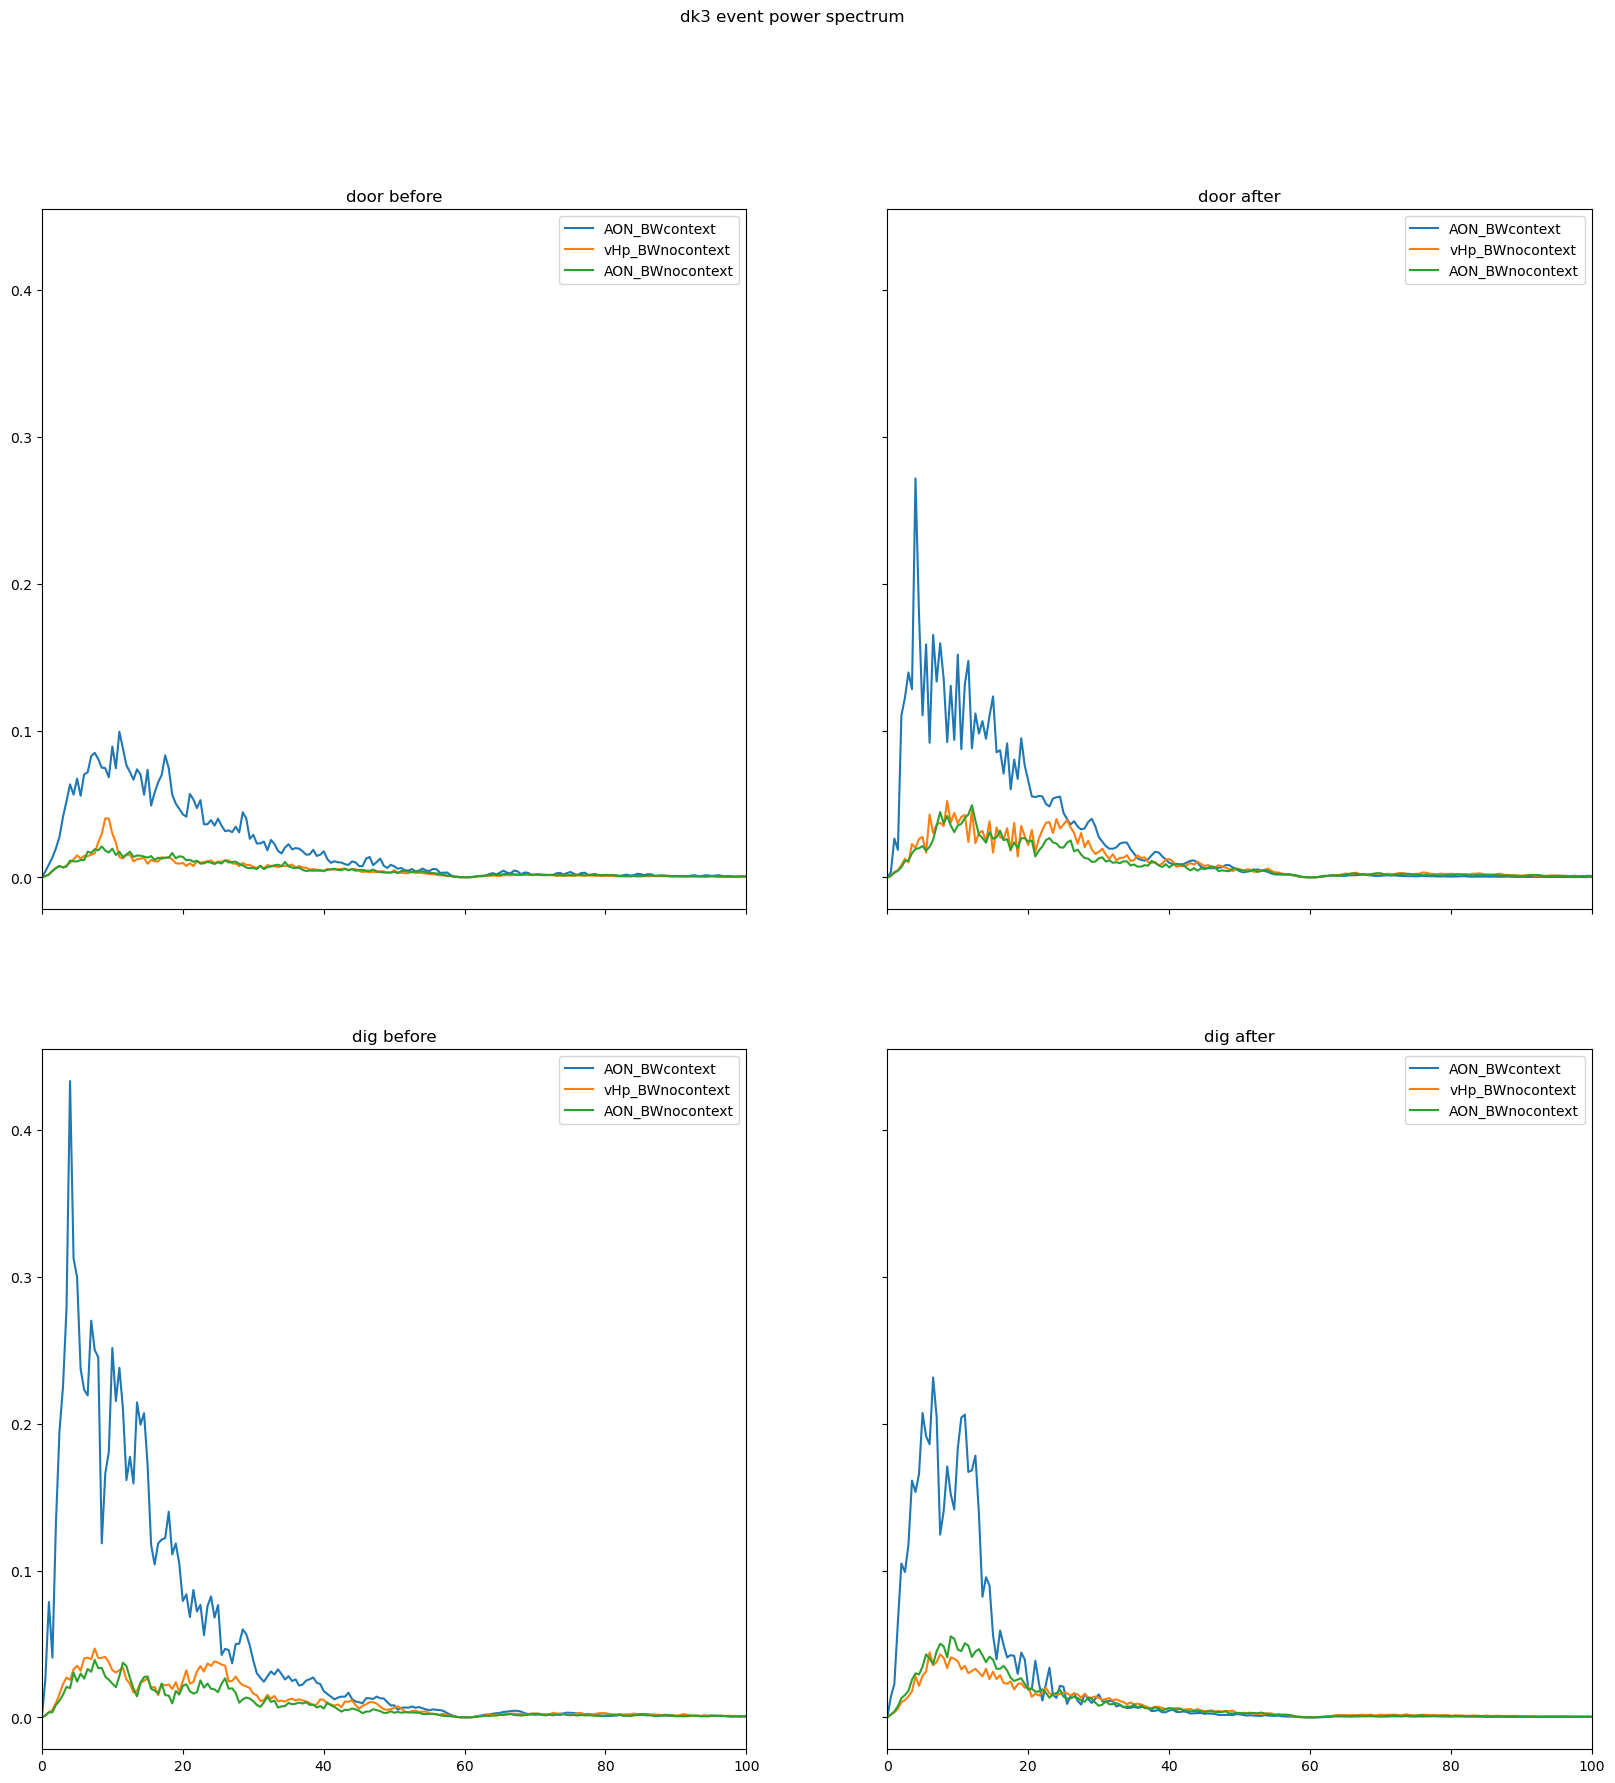

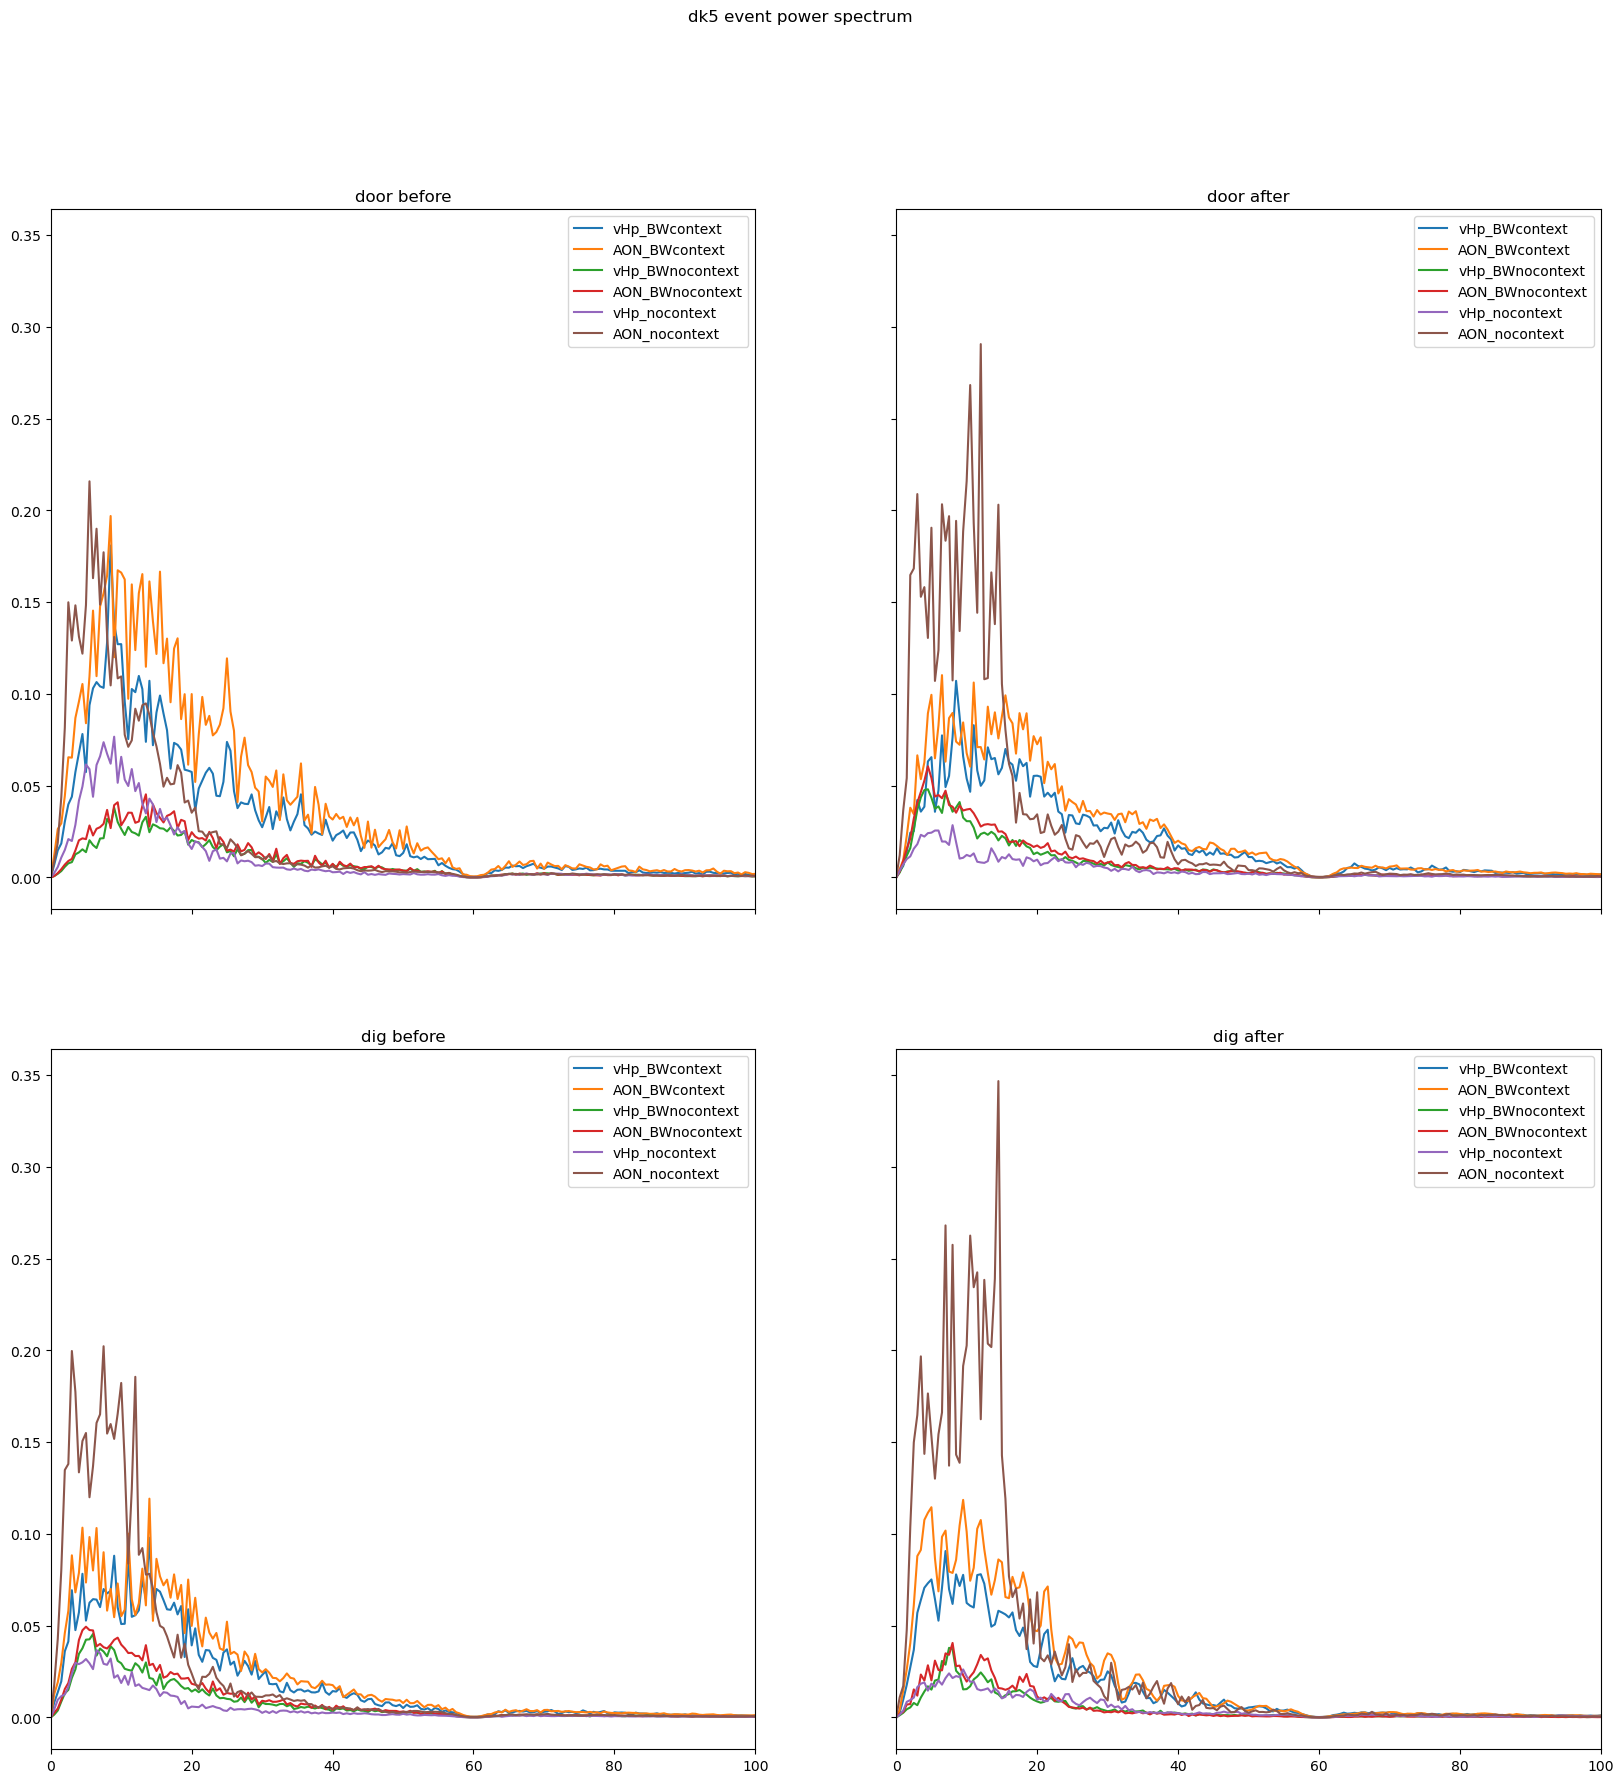

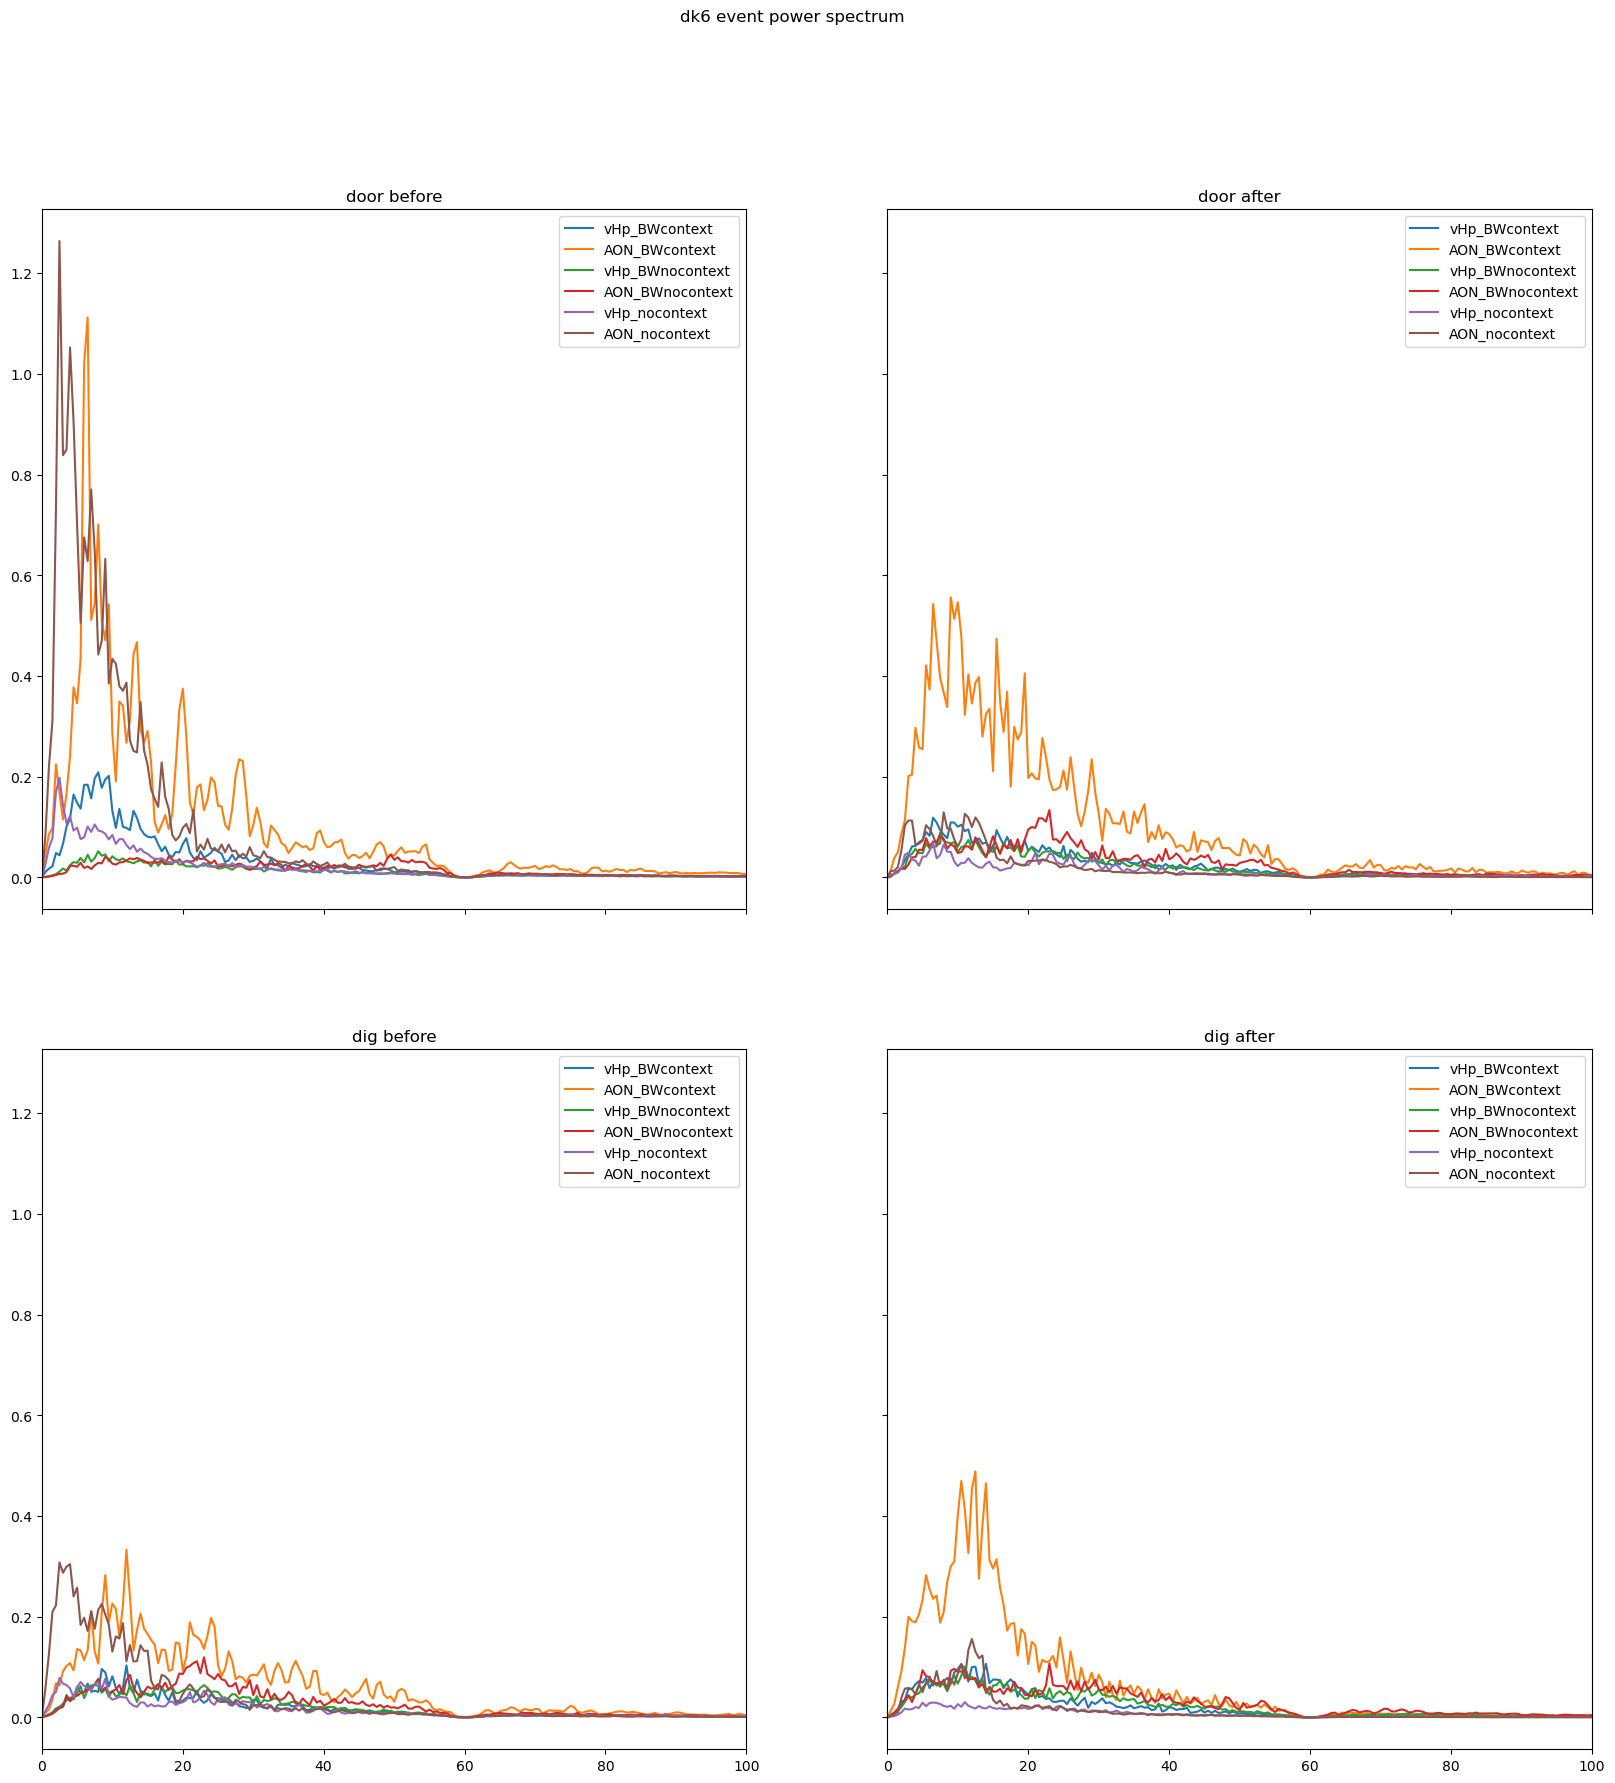

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming event_data_compiled_df is already defined and contains the necessary data
brain_areas = ['AON', 'vHp']
mouse_ids = np.unique(event_data_compiled_df['mouse_id'])
# mouse_ids = ['dk1']
events_list = ['door before', 'door after', 'dig before', 'dig after']

for mouse in mouse_ids:
    writer = pd.ExcelWriter(os.path.join(savepath,f'{mouse} average power spectrum around events.xlsx'), engine='xlsxwriter')

    mouse_data = event_data_compiled_df[event_data_compiled_df['mouse_id'] == mouse]
    
    # # Calculate door norm by individual
    # mouse_data['door norm by ind'] = mouse_data['door after'] - mouse_data['door before']
    
    # # Calculate the mean of the entire 'door before' column
    # mean_door_before = mouse_data['door before'].mean()
    # mouse_data['door norm by mean'] = mouse_data['door after'] - mean_door_before
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True, sharex=True)
    fig.suptitle(f'{mouse} event power spectrum')
    axs = axs.flatten()
    
    for event_num, event in enumerate(events_list):
        average_event_power_spectrum_df=pd.DataFrame()

        events_data = mouse_data[['mouse_id', 'channel_id', 'task', 'trial', event]]
        tasks = np.unique(events_data['task'])
        ax = axs[event_num]
        ax.set_title(f'{event}')
        for i, task in enumerate(tasks):
            
            task_data = events_data[events_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)

            if not task_data_vhp.empty:
                task_data_vhp_mean = np.mean(task_data_vhp[event], axis=0)


                faxis = np.linspace(0, 1000, num=len(task_data_vhp_mean))

                ax.plot(faxis, task_data_vhp_mean, label=f'vHp_{task}')

            if not task_data_aon.empty:
                task_data_aon_mean = np.mean(task_data_aon[event], axis=0)

                faxis = np.linspace(0, 1000, num=len(task_data_aon_mean))

                ax.plot(faxis, task_data_aon_mean, label=f'AON_{task}')
            
            average_event_power_spectrum_df[f'vHp_{task}']=task_data_vhp_mean
            average_event_power_spectrum_df[f'AON_{task}']=task_data_aon_mean
        average_event_power_spectrum_df.insert(0,'frequency',faxis)
        average_event_power_spectrum_df.to_excel(writer, sheet_name=event)
        ax.set_xlim(0, 100)
        ax.legend()
    writer.close()
    #fig.savefig(os.path.join(savepath, f'average_power_spectrum_around_events_{mouse}.png'),dpi=300, bbox_inches='tight')
    plt.show()

### Now I will attempt to make barplots for each rat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

brain_areas = ['AON', 'vHp']
mouse_ids = np.unique(averaged_data['mouse_id'])
all_rat_total_power=[]
for mouse in mouse_ids:
    mouse_data = averaged_data[averaged_data['mouse_id'] == mouse]
    tasks = np.unique(mouse_data['task'])

    x=np.arange(len(tasks))
    width = 0.25  # the width of the bars
    multiplier = 0
    task_dict={}
    for i, task in enumerate(tasks):
            task_data = mouse_data[mouse_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)
            
            if not task_data_vhp.empty:
                # Ensure all power spectra have the same length
                min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
                task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
                
                task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
                task_data_vhp_mean_total_power=np.sum(task_data_vhp_mean)
                print(task_data_vhp_mean_total_power)
                task_data_vhp_spectra=np.array(task_data_vhp_spectra)
                
                faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))

            if not task_data_aon.empty:
                # Ensure all power spectra have the same length
                min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
                task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
                task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
                task_data_aon_mean_total_power=np.sum(task_data_aon_mean)
                faxis=np.linspace(0,1000,num=len(task_data_aon_mean))
            task_dict[task]=(task_data_vhp_mean_total_power,task_data_aon_mean_total_power)
    # Create a bar plot
    fig, ax = plt.subplots()

    # Extract data for plotting
    tasks = list(task_dict.keys())
    vhp_values = [task_dict[task][0] for task in tasks]
    aon_values = [task_dict[task][1] for task in tasks]

    x = np.arange(len(tasks))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(x - width/2, vhp_values, width, label='vHp', color=color_scheme['vHp'][0])
    rects2 = ax.bar(x + width/2, aon_values, width, label='AON', color=color_scheme['AON'][0])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Tasks')
    ax.set_ylabel('Total Power')
    ax.set_title('Total Power {}'.format(mouse))
    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.legend()

    # Add labels to the bars
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

brain_areas = ['AON', 'vHp']
mouse_ids = np.unique(averaged_data['mouse_id'])
all_rat_total_power=[]
for mouse in mouse_ids:
    mouse_data = averaged_data[averaged_data['mouse_id'] == mouse]
    tasks = np.unique(mouse_data['task'])

    x=np.arange(len(tasks))
    width = 0.25  # the width of the bars
    multiplier = 0
    task_dict={}
    rat_total_power=[]
    
    for i, task in enumerate(tasks):
            task_data = mouse_data[mouse_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)
            
            if not task_data_vhp.empty:
                # Ensure all power spectra have the same length
                min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
                task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
                
                task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
                task_data_vhp_mean_total_power=np.sum(task_data_vhp_mean)
                print(task_data_vhp_mean_total_power)
                task_data_vhp_spectra=np.array(task_data_vhp_spectra)
                
                faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))
                gamma=[np.where(faxis>30)[0][0],np.where(faxis>80)[0][0]]
                theta=[np.where(faxis>4)[0][0],np.where(faxis>12)[0][0]]
                beta=[np.where(faxis>12)[0][0],np.where(faxis>30)[0][0]]
                theta_array=task_data_vhp_spectra[:, theta[0]:theta[1]]
                beta_array=task_data_vhp_spectra[:, beta[0]:beta[1]]
                gamma_array=task_data_vhp_spectra[:, gamma[0]:gamma[1]]
                row = pd.DataFrame({
                    'mouse': [mouse],
                    'task': [task],
                    'area': ['vHp'],
                    'theta': [np.median(theta_array,axis=1)],
                    'beta': [np.median(beta_array,axis=1)],
                    'gamma': [np.median(gamma_array,axis=1)]
                })
            rat_total_power.append(row)

            if not task_data_aon.empty:
                # Ensure all power spectra have the same length
                min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
                task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
                task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
                task_data_aon_mean_total_power = np.sum(task_data_aon_mean)
                print('aon',task_data_aon_mean_total_power)
                faxis = np.linspace(0, 1000, num=len(task_data_aon_mean))
                task_data_aon_spectra = np.array(task_data_aon_spectra)

                gamma = [np.where(faxis > 30)[0][0], np.where(faxis > 80)[0][0]]
                theta = [np.where(faxis > 4)[0][0], np.where(faxis > 12)[0][0]]
                beta = [np.where(faxis > 12)[0][0], np.where(faxis > 30)[0][0]]
                theta_array=task_data_aon_spectra[:, theta[0]:theta[1]]
                beta_array=task_data_aon_spectra[:, beta[0]:beta[1]]
                gamma_array=task_data_aon_spectra[:, gamma[0]:gamma[1]]
                row = pd.DataFrame({
                    'mouse': [mouse],
                    'task': [task],
                    'area': ['AON'],
                    'theta': [np.median(theta_array,axis=1)],
                    'beta': [np.median(beta_array,axis=1)],
                    'gamma': [np.median(gamma_array,axis=1)]
                })
            rat_total_power.append(row)
                #row=np.array(row)
    rat_total_power_df = pd.concat(rat_total_power, ignore_index=True)
    bands=['theta','beta','gamma']
    import seaborn as sns
    fig,axs=plt.subplots(1,3,figsize=(20,6))
    fig.suptitle('{}'.format(mouse))
    axs=axs.flatten()
    for i,bandi in enumerate(bands):
        ax=axs[i]
        # Explode the 'beta' column to convert lists into individual rows
        band_data = rat_total_power_df[['task', 'area', bandi]].copy()
        band_data_exploded = band_data.explode(bandi)
        band_data_exploded[bandi] = band_data_exploded[bandi].astype(float)
        # Create the boxplot with strip plot
        band_data_exploded = band_data_exploded.dropna(axis=0)

        sns.boxplot(x='task', y=bandi, hue='area', data=band_data_exploded, palette='Set2',showfliers=False,ax=ax)
        sns.stripplot(x='task', y=bandi, hue='area', data=band_data_exploded, dodge=True, jitter=True, color='black', alpha=1,ax=ax,legend='')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Tasks')
        ax.set_ylabel('Total Power dB')
        ax.set_title('Total Power {}'.format(bandi))
        ax.legend(title='Area', loc='upper right')
    fig.tight_layout()
    filename=f'{mouse} median power per band'
    fig.savefig(os.path.join(savepath,filename),dpi=300,bbox_inches='tight')

    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
bands=['theta','beta','gamma']

fig,axs=plt.subplots(1,3,figsize=(20,6))
axs=axs.flatten()
for i,bandi in enumerate(bands):
    ax=axs[i]
    # Explode the 'beta' column to convert lists into individual rows
    band_data = rat_total_power_df[['task', 'area', bandi]].copy()
    band_data_exploded = band_data.explode(bandi)
    band_data_exploded[bandi] = band_data_exploded[bandi].astype(float)
    # Create the boxplot with strip plot

    sns.boxplot(x='task', y=bandi, hue='area', data=band_data_exploded, palette='Set2',showfliers=False,ax=ax)
    sns.stripplot(x='task', y=bandi, hue='area', data=band_data_exploded, dodge=True, jitter=True, color='black', alpha=1,ax=ax,legend='')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Tasks')
    ax.set_ylabel('Total Power dB')
    ax.set_title('Total Power {}'.format(bandi))
    ax.legend(title='Area', loc='upper right')

plt.tight_layout()
plt.show()

In [86]:
import seaborn as sns

# load the dataframe
tips = sns.load_dataset('tips')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

# Assuming rat_total_power_df is already defined and contains the necessary data
# Aggregate the beta values by taking the mean
rat_total_power_df['beta_mean'] = rat_total_power_df['beta'].apply(lambda x: np.mean(x))

fig, ax = plt.subplots()

tasks = np.unique(rat_total_power_df['task'])
x = np.arange(len(tasks))

aon_values = rat_total_power_df[rat_total_power_df['area'] == 'AON']
vhp_values = rat_total_power_df[rat_total_power_df['area'] == 'vHp']

# Prepare data for boxplot
data_vhp = [vhp_values[vhp_values['task'] == task]['beta_mean'].values for task in tasks]
data_aon = [aon_values[aon_values['task'] == task]['beta_mean'].values for task in tasks]

# Create boxplots
box_vhp = ax.boxplot(data_vhp, positions=x - 0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color_scheme['vHp'][0]), labels=tasks)
box_aon = ax.boxplot(data_aon, positions=x + 0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color_scheme['AON'][0]), labels=tasks)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Tasks')
ax.set_ylabel('Total Power (Beta Mean)')
ax.set_title('Total Power by Task and Brain Area')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend([box_vhp["boxes"][0], box_aon["boxes"][0]], ['vHp', 'AON'], loc='upper right')

fig.tight_layout()

plt.show()

In [ ]:
print(task_dict.items())

In [ ]:
print(np.where(faxis>6))